In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def find_diagnose(filename):

    with open(filename, "r") as file:
        lines = file.readlines()

    for line in lines:
        tofind = "# Reason for admission: "
        start = len(tofind)
        if tofind in line:
            diagnose = line[start:].strip()
    if diagnose == "n/a":
        return None
    else: #some signals in the dataset don't have a diagnose
        return diagnose

In [3]:
def remove_baselineshift_window(window):
    #compute median
    modes = np.median(window, axis = 1)
    
    to_return = np.zeros_like(window)
    #signal - mode
    for ch, mode in enumerate(modes):
        w_ch = window[ch, :]
        if mode < 0:
            to_return[ch, :] = w_ch - mode
        else:
            to_return[ch, :] = w_ch + mode
        #return
    return to_return

In [4]:
import wfdb

In [5]:
def multichannel_resample(signal, new_lenght):
    nchs = 15
    resampled_signal = np.zeros((new_lenght, nchs))
    for ch in range(nchs):
        resampled_signal[:, ch] = resample(signal[:, ch], new_lenght)
        #print(resampled_signal[:, ch].shape, resample(signal[:, ch], new_fs).shape)
    return resampled_signal

In [6]:
from scipy.signal import butter, lfilter, iirnotch

def bandpass(lowcut, highcut, order=3, fs = 500):
    
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def notch_filter(cutoff, q, fs=500):
    
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a

def myfilter(lowcut, highcut, powerline, data):
    
    nchs = 12
    filtered_data = np.zeros_like(data)
    for ch in range(nchs):
        ch_data = data[:, ch]
        b, a = bandpass(lowcut, highcut)   
        x = lfilter(b, a, ch_data)
        f, e = notch_filter(powerline, 30)
        z = lfilter(f, e, x) 
        filtered_data[:, ch] = (x)
    return filtered_data

In [7]:
import os 
import numpy as np 
from scipy.signal import resample

cwd = "C:\\Users\\Utente\\Desktop\\Uni\\ECG Anomaly Detector Clean\\ptb-diagnostic-ecg-database-1.0.0"
patients = [filename for filename in os.listdir(cwd) if "patient" in filename]
y_patients = {}
signals = {}
map_signals = {} #i: patient/record
all_signals = []
notfiltered_signals = []
n = len(patients)
j = 0
for i, patient in enumerate(patients):
    
    print(i+1, "/", n, end="\r")
    patient_dir = cwd + os.sep + patient + os.sep
    records = [filename for filename in os.listdir(patient_dir) if ".dat" in filename]
    y_patients[patient] = {}
    signals[patient] = {}
    for record in records:
        filename = record[:-4] + ".hea"
        hea_file = patient_dir + filename
        diagnose = find_diagnose(hea_file)
        if diagnose is None:
            continue
        y_patients[patient][record] = diagnose
        path_record = patient_dir + record
        signal, fields = wfdb.rdsamp(path_record[:-4])
        signal = multichannel_resample(signal, int(signal.shape[0]/2)) #from 1000hz to 500hz
        notfiltered_signals.append(signal)
        filtered_signal = myfilter(0.5, 100, 50, signal)
        signals[patient][record] = filtered_signal
        all_signals.append(filtered_signal)
        map_signals[j] = patient + "/" + record    
        j += 1
        
#all_signals = np.array(all_signals)
#notfiltered_signals = np.array(notfiltered_signals)

In [8]:
y_all = [diagnose for patient, temp in y_patients.items() for record, diagnose in temp.items()]
uqs, cnts = np.unique(y_all, return_counts = True)
for i, uq in enumerate(uqs):
    cnt = cnts[i]
    print(uq, ":", cnt)

Bundle branch block : 17
Cardiomyopathy : 17
Dysrhythmia : 16
Healthy control : 80
Heart failure (NYHA 2) : 1
Heart failure (NYHA 3) : 1
Heart failure (NYHA 4) : 1
Hypertrophy : 7
Myocardial infarction : 368
Myocarditis : 4
Palpitation : 1
Stable angina : 2
Unstable angina : 1
Valvular heart disease : 6


In [9]:
def binarize(y_int, map_y):

    y_bin = y_int.copy()
    map_bin = {}
    for i, target in map_y.items():
        if target == "Healthy control": #sostituire con NORMAL/CONTROL
            y_bin[y_bin == i] = 0
            map_bin[target] = 0
        else:
            y_bin[y_bin == i] = 1
            map_bin[target] = 1
    return y_bin, map_bin

In [10]:
def prepare_target(y_all):

    y_int = y_all.copy()
    y_int = np.array(y_int)
    map_y = {}
    uqs = np.unique(y_all)
    for i, uq in enumerate(uqs):
        map_y[i] = uq
        y_int[y_int == uq] = i

    y_int = y_int.astype(int)
    y_bin, map_bin = binarize(y_int, map_y)

    return y_int, y_bin, map_y, map_bin


In [11]:
y_int, y_bin, map_y, map_bin = prepare_target(y_all)
y_bin

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [12]:
np.unique(y_int, return_counts = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([ 17,  17,  16,  80,   1,   1,   1,   7, 368,   4,   1,   2,   1,
          6], dtype=int64))

In [13]:
map_bin

{'Bundle branch block': 1,
 'Cardiomyopathy': 1,
 'Dysrhythmia': 1,
 'Healthy control': 0,
 'Heart failure (NYHA 2)': 1,
 'Heart failure (NYHA 3)': 1,
 'Heart failure (NYHA 4)': 1,
 'Hypertrophy': 1,
 'Myocardial infarction': 1,
 'Myocarditis': 1,
 'Palpitation': 1,
 'Stable angina': 1,
 'Unstable angina': 1,
 'Valvular heart disease': 1}

In [14]:
#!pip install umap-learn

In [15]:
len(all_signals), len(y_bin)

(522, 522)

In [16]:
from EcgStuffs.src.windows.WindowingUtils import sliding_window
    
windows = []
y_bin_win = []

for i, signal in enumerate(all_signals):
    print("Signal", i+1, "/", len(all_signals), end="\r")
    signal = signal.T
    label = y_bin[i]
    windows_signal = sliding_window(signal[:, 3000:], 2000, 1500) 
    #print()
    for j, window in enumerate(windows_signal):
        #if j+1 in np.arange(1, len(windows_signal), 1000):
            #print("Window", j+1, "/", len(windows_signal), end="\r")
        windows.append(window)
        y_bin_win.append(label)

windows  = np.array(windows)
y_bin_win = np.array(y_bin_win)

In [17]:
windows.shape

(18380, 15, 2000)

In [18]:
y_bin_win.shape

(18380,)

In [24]:
windows_f = []
for window in windows:
    windows_f.append(window.flatten())
windows_f = np.array(windows_f)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(windows_f, y_bin_win, test_size=0.5, stratify = y_bin_win)

In [68]:
# Initialize and train the MLP model
from sklearn.neural_network import MLPClassifier
#(64, 32)
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=20, learning_rate="adaptive",  random_state=42, verbose = True)
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.45708492
Iteration 2, loss = 0.21497775
Iteration 3, loss = 0.12715102
Iteration 4, loss = 0.07377543
Iteration 5, loss = 0.03894125
Iteration 6, loss = 0.02228842
Iteration 7, loss = 0.01341027
Iteration 8, loss = 0.00797462
Iteration 9, loss = 0.00420413
Iteration 10, loss = 0.00274880
Iteration 11, loss = 0.00212899
Iteration 12, loss = 0.00172669
Iteration 13, loss = 0.00144885
Iteration 14, loss = 0.00123516
Iteration 15, loss = 0.00106884
Iteration 16, loss = 0.00093521
Iteration 17, loss = 0.00082657
Iteration 18, loss = 0.00073735
Iteration 19, loss = 0.00066291
Iteration 20, loss = 0.00059987


D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(64, 32), learning_rate='adaptive',
              max_iter=20, random_state=42, verbose=True)

In [69]:
# Make predictions on the test set
from sklearn.metrics import accuracy_score, classification_report

y_preds = mlp.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_preds)
report = classification_report(y_test, y_preds)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)

Accuracy: 0.8888
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.55      0.62      1501
           1       0.92      0.96      0.93      7689

    accuracy                           0.89      9190
   macro avg       0.81      0.75      0.78      9190
weighted avg       0.88      0.89      0.88      9190



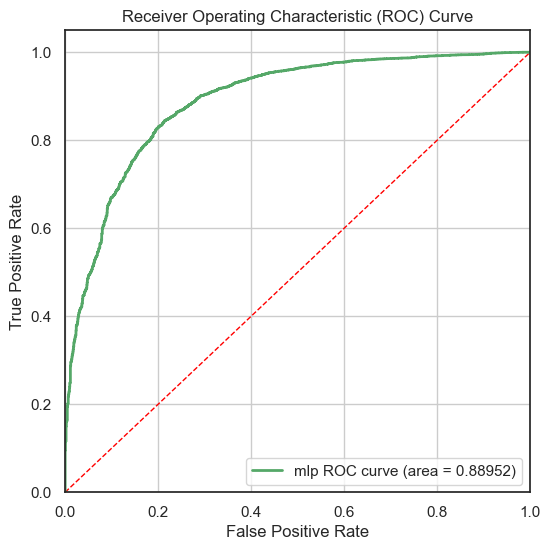

In [70]:
import ml 
fig, model, best_score = ml.models_roc_curves([("mlp", mlp)], X_test, y_test)

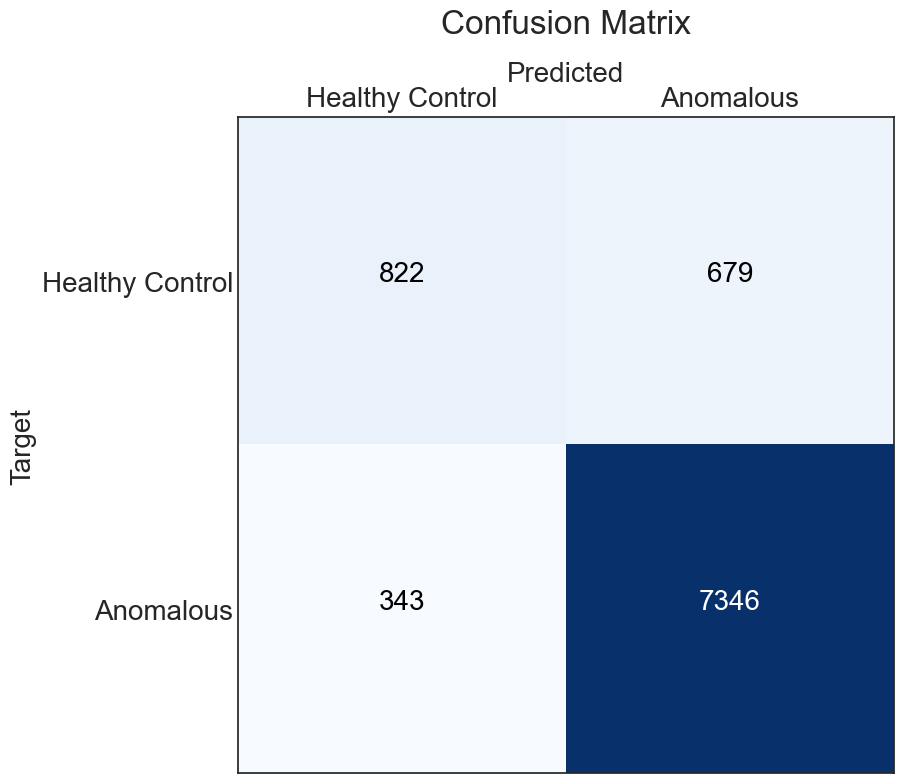

In [71]:
y_preds = []
y_preds = mlp.predict(X_test)
metrics, to_print = validate_model(y_test, y_preds)

In [72]:
print(to_print)

Accuracy: 0.8887921653971709 
 F1 score: 0.9349624538627975 
 Sensitivity: 0.9553908180517623 
 Specificity: 0.54763491005996 
 ROC AUC score: 0.7515128640558612 
 Confusion Matrix: 
 [[ 822  679]
 [ 343 7346]] 
 Classification Report: 
               precision    recall  f1-score   support

           0       0.71      0.55      0.62      1501
           1       0.92      0.96      0.93      7689

    accuracy                           0.89      9190
   macro avg       0.81      0.75      0.78      9190
weighted avg       0.88      0.89      0.88      9190
 



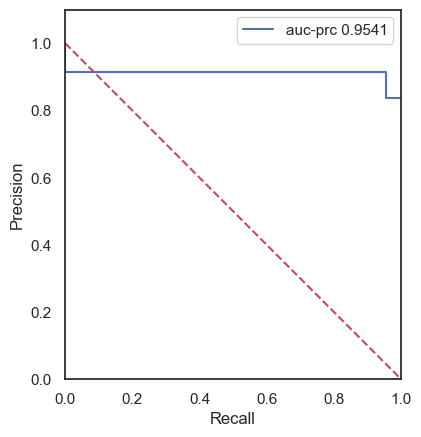

In [73]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, auc

prec, recall, _ = precision_recall_curve(y_test, y_preds)
auc_pr = auc(recall, prec)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(label="auc-prc {}".format(round(auc_pr, 4)))
plt.plot([0, 1], [1, 0], "--r")
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.legend()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import pytorch_lightning as pl
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the MLP model using PyTorch Lightning
class LitMLP(pl.LightningModule):
    def __init__(self, input_size, output_size, learning_rate=1e-3):
        super(LitMLP, self).__init__()
        self.save_hyperparameters()  # Save hyperparameters such as input/output sizes
        self.learning_rate = learning_rate

        # Define the layers
        self.fc1 = nn.Linear(input_size, 100)  # Input layer to first hidden layer
        self.fc2 = nn.Linear(100, 50)         # First hidden layer to second hidden layer
        self.fc3 = nn.Linear(50, output_size) # Second hidden layer to output layer
        self.relu = nn.ReLU()                 # Activation function

        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        # Accuracy metric
        self.accuracy = torchmetrics.Accuracy()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer (no activation here, logits will be used)
        return x

    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self.forward(X)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        logits = self.forward(X)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        # Use ReduceLROnPlateau to reduce learning rate if validation loss plateaus
        scheduler = {
            'scheduler': ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True),
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

# DataLoader setup (convert your numpy data to PyTorch tensors)
from torch.utils.data import DataLoader, TensorDataset

def create_dataloader(X, y, batch_size=32):
    tensor_X = torch.tensor(X, dtype=torch.float32)
    tensor_y = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(tensor_X, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Assuming you have X_train, y_train, X_val, y_val already as numpy arrays
input_size = X_train.shape[1]
output_size = len(set(y_train))  # Number of classes for classification

# Create DataLoader for training and validation
train_loader = create_dataloader(X_train, y_train, batch_size=32)
val_loader = create_dataloader(X_val, y_val, batch_size=32)

# Initialize the model
model = LitMLP(input_size=input_size, output_size=output_size, learning_rate=1e-3)

# Train using PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=25, accelerator='gpu', devices=1, log_every_n_steps=10, verbose=True)
trainer.fit(model, train_loader, val_loader)
